In [1]:
import numpy as np
import pandas as pd
import pickle
data = pickle.load(open('../data/60_second_data1.p','rb'))

In [2]:
from hrvanalysis import get_time_domain_features
from joblib import Parallel,delayed
data.shape

(200893, 60, 11)

In [3]:
def get_data(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>20:
        return [],[],[],[],[],[]
    m = np.nanmean(ecg_rr[ecg_rr>0])
    s = np.nanstd(ecg_rr[ecg_rr>0])
    ecg_rr[np.isnan(ecg_rr)] = 0
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         index = ppg_rr>0
#         ppg_qual = ppg_qual[index]
#         ppg_rr = ppg_rr[index]
        index = np.isnan(ppg_rr)
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<10:
            continue
        ppg_qual[index] = -1
        ppg_rr[index] = np.nanmean(ppg_rr)
        y.append(ppg_rr.reshape(1,60,1))
        tmp = a[:,np.array([-3,-4,-5,-6])].reshape(1,60,4)
        tmp[np.isnan(tmp)] = 0
        tmp[tmp==0] = 0
        X.append(tmp)
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
#         for j in np.linspace(0,.9,20):
#             index = ppg_qual>j
#             ppg_qual = ppg_qual[index]
#             ppg_rr = ppg_rr[index]
#             if len(ppg_rr)<10:
#                 continue
#             f = list(get_time_domain_features(ppg_rr).values())
#             f1 = list(get_time_domain_features(ecg_rr).values())
#             q = [np.percentile(ppg_qual,20),np.median(ppg_qual),len(ppg_rr)/60]
#             features.append(np.array(f1+f+q))
    return X,y,ecg,means,stds,quals

df_col = Parallel(n_jobs=10,verbose=1)(delayed(get_data)(a) for a in data if len(a[~np.isnan(a[:,-1]),-1])>20)    

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s
[Parallel(n_jobs=10)]: Done 3850 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 27590 tasks      | elapsed:    5.0s
[Parallel(n_jobs=10)]: Done 27912 out of 27912 | elapsed:    5.1s finished


In [4]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for a in df_col:
    if len(a[0])==0:
        continue
    X.extend(a[0])
    y.extend(a[1])
    ecg.extend(a[2])
    means.extend(a[3])
    stds.extend(a[4])
    quals.extend(a[5])

In [5]:
len(X)

23889

In [6]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y),np.concatenate(ecg),\
np.array(means).reshape(-1,1,1),np.array(stds).reshape(-1,1,1),np.concatenate(quals)

In [7]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,TimeDistributed,Dense,Flatten,Reshape,Lambda
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses

X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X, y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X.shape,y.shape,y_val.shape,means_val.shape,stds_val.shape)

Using TensorFlow backend.


(23889, 60, 4) (23889, 60, 1) (3201, 60, 1) (3201, 1, 1) (3201, 1, 1)


In [13]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1,input_shape[2])

def mean(x):
    return K.mean(x, axis=1, keepdims=True)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1,input_shape[2])

def mean1(x):
    return K.std(x, axis=1, keepdims=True)

timesteps = 60
input_dim = 4
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(LSTM(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
encoded = TimeDistributed(Dense(10,activation='relu'))(encoded)
encoded = Flatten()(encoded)
encoded = Dense(60,activation='relu')(encoded)
encoded = Reshape((60, 1),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=[inputs], outputs=[encoded,decoded,decoded1])
# encoder = Model(inputs, encoded)
losses = {
    "std":"mae",
    "mean": "mae",
    "sequence": "mae"
}
lossWeights = {"mean": 0, "sequence": 1,"std":0}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 4)        0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 60, 120)      31200       input_4[0][0]                    
__________________________________________________________________________________________________
time_distributed_4 (TimeDistrib (None, 60, 10)       1210        bidirectional_4[0][0]            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 600)          0           time_distributed_4[0][0]         
____________________________________________________________________________________________

In [14]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, [y_train,means_train,stds_train],
                epochs=300,
                batch_size=100,
                shuffle=True,
                validation_data=(X_val,[y_val,means_val,stds_val]),callbacks=callbacks_list)

Train on 12804 samples, validate on 3201 samples
Epoch 1/300
12804/12804 [==============================] - 13s 1ms/step - loss: 405.3839 - sequence_loss: 405.4968 - mean_loss: 229.0522 - std_loss: 298.1102 - val_loss: 372.1897 - val_sequence_loss: 368.9360 - val_mean_loss: 236.7324 - val_std_loss: 236.7639

Epoch 00001: val_loss improved from inf to 372.18966, saving model to ../models/base_LSTM.hdf5
Epoch 2/300
12804/12804 [==============================] - 14s 1ms/step - loss: 237.7614 - sequence_loss: 237.5338 - mean_loss: 145.0697 - std_loss: 76.5701 - val_loss: 188.6758 - val_sequence_loss: 184.9572 - val_mean_loss: 100.6749 - val_std_loss: 24.5804

Epoch 00002: val_loss improved from 372.18966 to 188.67576, saving model to ../models/base_LSTM.hdf5
Epoch 3/300
12804/12804 [==============================] - 14s 1ms/step - loss: 184.6793 - sequence_loss: 184.8969 - mean_loss: 95.8131 - std_loss: 25.7104 - val_loss: 176.4137 - val_sequence_loss: 176.8854 - val_mean_loss: 90.1070 - v


Epoch 00025: val_loss did not improve from 152.11013
Epoch 26/300
12804/12804 [==============================] - 15s 1ms/step - loss: 161.5069 - sequence_loss: 161.3199 - mean_loss: 72.4848 - std_loss: 18.9267 - val_loss: 162.0285 - val_sequence_loss: 157.8278 - val_mean_loss: 71.2888 - val_std_loss: 19.8967

Epoch 00026: val_loss did not improve from 152.11013
Epoch 27/300
12804/12804 [==============================] - 16s 1ms/step - loss: 159.7915 - sequence_loss: 159.8406 - mean_loss: 70.2424 - std_loss: 20.0310 - val_loss: 160.2885 - val_sequence_loss: 156.0315 - val_mean_loss: 69.5967 - val_std_loss: 19.8011

Epoch 00027: val_loss did not improve from 152.11013
Epoch 28/300
12804/12804 [==============================] - 16s 1ms/step - loss: 159.4319 - sequence_loss: 159.3934 - mean_loss: 70.3343 - std_loss: 18.6076 - val_loss: 160.2701 - val_sequence_loss: 156.2654 - val_mean_loss: 68.1550 - val_std_loss: 17.7788

Epoch 00028: val_loss did not improve from 152.11013
Epoch 29/300


12804/12804 [==============================] - 16s 1ms/step - loss: 148.2863 - sequence_loss: 148.1176 - mean_loss: 63.8354 - std_loss: 34.3088 - val_loss: 149.4322 - val_sequence_loss: 145.6726 - val_mean_loss: 62.7744 - val_std_loss: 33.6911

Epoch 00051: val_loss did not improve from 148.73858
Epoch 52/300
12804/12804 [==============================] - 16s 1ms/step - loss: 149.0360 - sequence_loss: 148.9339 - mean_loss: 64.0689 - std_loss: 33.7074 - val_loss: 151.8654 - val_sequence_loss: 147.9777 - val_mean_loss: 64.4200 - val_std_loss: 33.2799

Epoch 00052: val_loss did not improve from 148.73858
Epoch 53/300
12804/12804 [==============================] - 16s 1ms/step - loss: 148.6597 - sequence_loss: 148.6652 - mean_loss: 63.7491 - std_loss: 32.9504 - val_loss: 148.7140 - val_sequence_loss: 144.7965 - val_mean_loss: 62.3414 - val_std_loss: 33.5244

Epoch 00053: val_loss improved from 148.73858 to 148.71402, saving model to ../models/base_LSTM.hdf5
Epoch 54/300
12804/12804 [======

12804/12804 [==============================] - 16s 1ms/step - loss: 148.4753 - sequence_loss: 148.8475 - mean_loss: 65.0509 - std_loss: 31.9683 - val_loss: 149.8329 - val_sequence_loss: 146.0175 - val_mean_loss: 63.8145 - val_std_loss: 28.1655

Epoch 00076: val_loss did not improve from 145.33200
Epoch 77/300
12804/12804 [==============================] - 16s 1ms/step - loss: 150.0894 - sequence_loss: 149.9463 - mean_loss: 66.7480 - std_loss: 31.1762 - val_loss: 158.4414 - val_sequence_loss: 154.6408 - val_mean_loss: 71.8790 - val_std_loss: 36.9556

Epoch 00077: val_loss did not improve from 145.33200
Epoch 78/300
12804/12804 [==============================] - 16s 1ms/step - loss: 276.5665 - sequence_loss: 275.9464 - mean_loss: 185.3673 - std_loss: 131.8042 - val_loss: 189.9521 - val_sequence_loss: 186.4343 - val_mean_loss: 100.0837 - val_std_loss: 56.1098

Epoch 00078: val_loss did not improve from 145.33200
Epoch 79/300
12804/12804 [==============================] - 16s 1ms/step - lo

In [15]:
from keras.models import load_model
sequence_autoencoder = load_model(filepath)

In [16]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1[0]
mean_pred = y_pred1[1]
stds_pred = y_pred1[2]

In [17]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((7884, 60, 1), (7884, 1, 1), (7884, 1, 1))

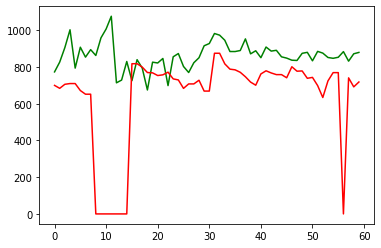

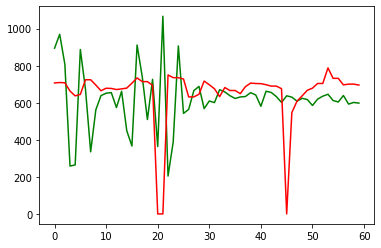

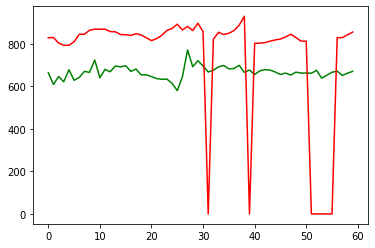

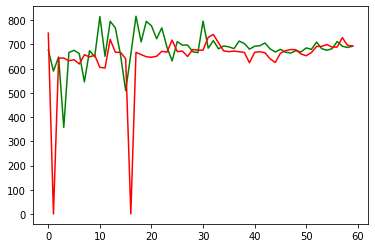

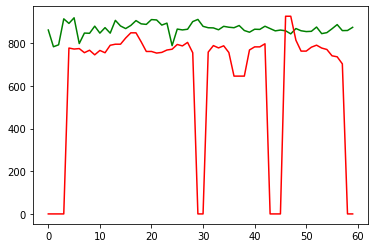

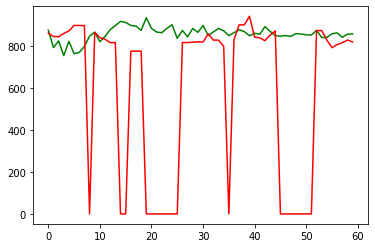

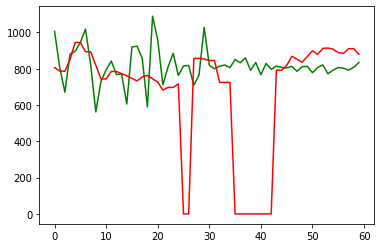

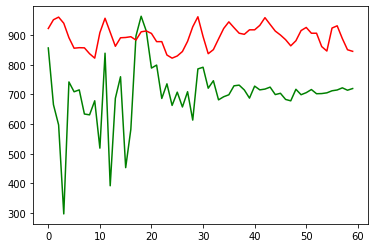

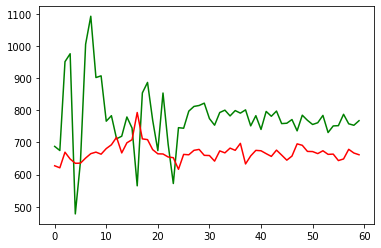

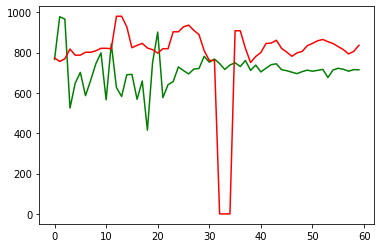

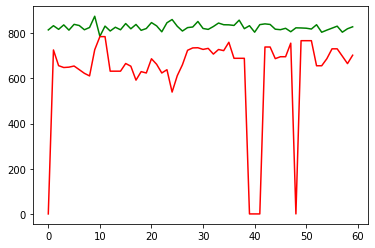

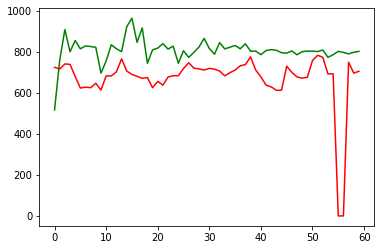

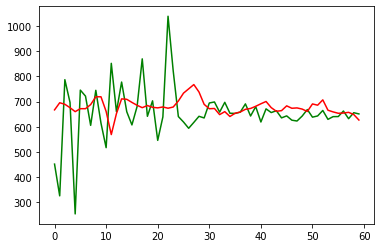

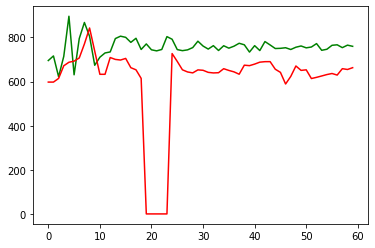

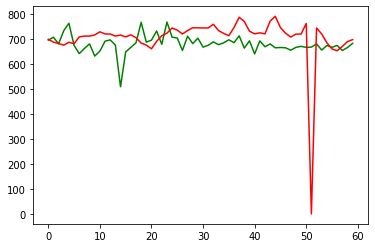

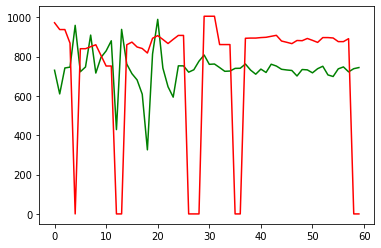

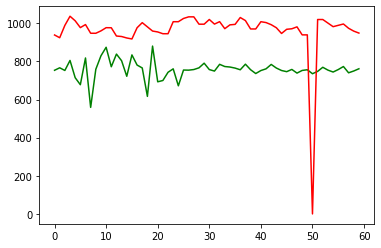

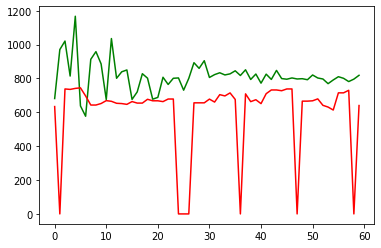

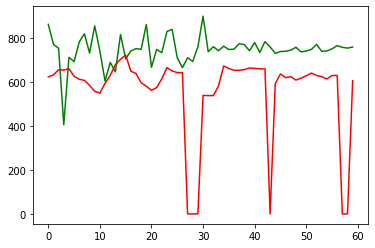

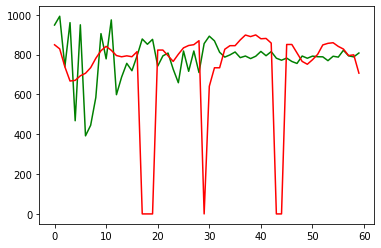

In [18]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[::-1][:20]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#         plt.plot(X[i,:,:],'r')
#     plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [19]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [20]:
X = X[X[:,0]>-1]
X = X[X[:,2]>0]
X = X[X[:,3]>0]

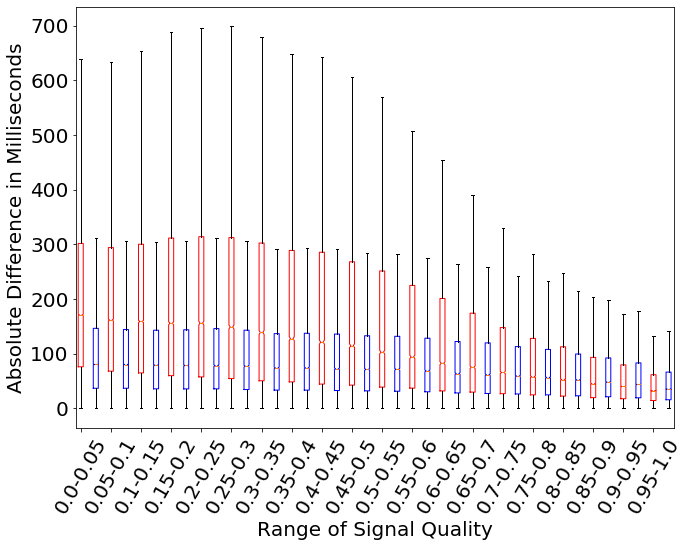

In [21]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    y1.append(list(np.abs(temp[:,1]-temp[:,2])))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [26]:
for i in range(ecg_test.shape[0]):
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    y_pred_min = y_pred[i].reshape(-1)
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    
    
    

56
56
60
59
60
59
55
59
60
59
59
58
54
57
60
60
59
59
58
57
59
58
56
60
56
60
54
59
59
57
55
60
57
60
54
60
58
53
60
60
57
60
54
60
59
60
60
57
60
56
60
58
58
59
59
59
58
60
56
58
56
60
58
60
58
58
55
58
60
54
55
56
59
60
56
60
55
60
60
59
52
60
59
60
56
52
60
60
60
55
58
60
58
59
56
60
60
56
56
58
58
60
45
52
60
57
60
60
60
60
52
60
55
59
59
57
60
57
59
52
58
57
59
60
59
60
57
56
60
56
54
57
59
51
58
57
60
55
58
57
60
57
57
54
57
60
52
60
57
56
60
53
58
55
60
60
57
50
60
57
59
57
56
58
60
54
58
54
60
60
52
57
60
60
52
60
60
58
59
60
58
59
57
59
60
55
59
60
53
58
60
60
60
60
60
54
57
56
59
60
53
60
53
60
60
55
60
55
58
57
58
58
60
56
57
58
57
57
58
54
60
56
56
57
55
60
55
55
56
57
60
57
59
60
56
60
53
56
59
60
60
56
60
59
59
60
56
60
58
55
60
58
55
56
60
59
60
60
54
58
60
60
60
55
59
56
60
60
57
60
55
60
59
60
57
60
57
60
58
60
55
51
60
57
59
60
60
55
58
59
59
59
60
59
53
58
55
59
57
58
58
59
59
60
58
57
60
60
59
54
60
54
56
57
58
58
60
58
56
58
59
56
59
58
59
56
60
58
58
60
60
60
60
5

51
59
60
58
56
59
60
56
58
58
60
58
57
56
58
60
53
55
57
60
57
55
55
60
60
60
60
58
60
56
56
57
60
51
59
50
60
60
52
60
60
60
59
56
60
60
59
57
58
60
55
58
60
60
57
56
60
54
56
57
53
59
56
59
57
58
60
60
59
58
57
60
60
52
60
59
57
59
56
51
60
60
57
60
58
56
59
60
58
58
56
55
59
58
53
60
54
59
54
49
53
50
58
57
60
58
52
60
55
59
55
59
54
60
58
56
54
60
60
57
58
60
60
58
56
53
59
60
60
59
55
60
59
60
56
60
54
60
60
57
60
60
60
60
59
57
60
57
60
55
59
55
60
60
54
59
60
55
57
60
60
58
51
58
58
56
56
60
58
57
57
57
51
52
57
55
60
59
60
52
53
60
60
60
55
57
60
60
60
59
50
60
57
58
56
57
59
57
57
59
55
56
60
55
58
55
54
59
60
56
57
56
60
55
50
60
60
57
58
55
60
60
57
57
57
60
59
50
60
57
60
58
57
56
55
59
52
58
60
52
60
60
60
60
60
56
60
54
58
57
60
55
57
60
60
52
59
58
60
58
54
57
59
60
59
59
60
59
59
59
58
60
56
58
60
60
60
54
60
59
55
59
57
57
58
60
55
58
57
59
59
58
60
60
54
56
54
56
60
55
58
58
59
60
58
60
54
60
58
59
58
58
60
59
60
60
58
58
59
51
57
55
60
59
59
56
60
60
59
58
55
55
59
5

50
56
60
60
58
59
60
55
57
55
58
59
56
60
58
60
60
59
60
52
53
59
58
59
54
53
55
60
55
59
59
57
50
58
60
57
58
59
55
52
60
55
59
56
59
58
60
59
57
57
55
54
58
54
59
54
54
60
60
60
53
60
58
58
60
54
56
60
55
56
60
55
53
60
54
57
57
56
60
60
59
57
56
59
60
53
60
60
54
57
54
53
58
55
54
60
57
57
58
60
55
57
60
60
53
56
57
60
58
55
59
59
56
57
59
58
57
60
56
57
59
60
56
58
58
60
59
58
60
58
51
59
60
59
56
60
60
53
60
56
60
55
55
57
60
54
58
58
55
51
59
60
60
60
52
60
60
56
59
60
59
56
49
60
56
60
60
59
56
56
60
58
57
60
60
59
55
60
57
60
56
60
55
59
56
52
57
57
59
60
53
57
57
60
59
55
60
56
60
58
60
60
58
60
57
57
60
59
59
56
54
60
59
60
58
60
57
59
58
58
59
58
59
60
60
60
58
57
58
60
60
53
59
56
60
57
53
60
59
59
60
54
58
57
56
59
60
57
60
53
55
60
58
60
59
55
58
58
59
58
58
56
60
55
59
60
59
59
57
60
57
58
57
56
60
59
59
56
56
60
56
58
59
60
60
58
53
60
60
54
58
55
59
60
54
59
60
57
58
59
58
60
60
56
54
60
58
60
56
57
56
56
60
56
59
57
56
60
60
60
60
60
54
60
60
55
59
58
60
60
58
56
58
5

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
# plt.hist(ecg_test.reshape(-1),50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))